In [251]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
from datetime import datetime
import os
import time
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
main_url="https://townhall.virginia.gov/L/Comments.cfm?GdocForumID=1953"

orig_url="https://townhall.virginia.gov/L/GDocForum.cfm?GDocForumID=452"

In [6]:
html_content = requests.get(main_url).text
soup = BeautifulSoup(html_content, "lxml")
main_tab = soup.find('table')

In [73]:
# save off raw html
with open("raw_html.txt", "w") as text_file:
    text_file.write(html_content)

In [ ]:
with open('raw_html.txt', 'r') as file:
    html_content = file.read()

In [28]:
df = pd.read_html(str(main_tab))[0]

In [57]:
urls = [re.search('.+=([0-9]+)', r.a['href']).group(1) for r in main_tab.find_all('tr')]
df['commentId'] = urls[1:]

In [66]:
df.head(3)

,Comment Title,Commenter,Date,commentId,full_comment
0,I am strongly opposed.,Latosha Misciagna,9/26/22 4:27 pm,136285,
1,Awful legislation!,Vincent J. Albiani,9/26/22 4:27 pm,136284,
2,This is a terrible policy decision.,Gaye Degrazio,9/26/22 4:27 pm,136283,


In [41]:
df.tail(3)

,Comment Title,Commenter,Date
7313,Transgender pronkun,Anonymous (128950),9/26/22 5:24 am
7314,Wholly support the 2022 guidance,"LH, Fairfax County Public Schools mother",9/26/22 2:37 am
7315,Protect Kids,Cassidy Moulton-Hill,9/26/22 12:30 am


In [72]:
# loop over all entries, update in place
df['full_comment'] = ''
for i in range(df.shape[0]):
    url=f"https://townhall.virginia.gov/L/viewcomments.cfm?commentid={df.loc[i,'commentId']}"
    soup2 = BeautifulSoup(requests.get(url).text, "lxml")
    df.loc[i,'full_comment'] = soup2.find(attrs={"class": "divComment"}).text

In [75]:
df.to_csv('1953_comments.csv')

## Alt method - full comments page, paginated

In [252]:
base_url = "https://townhall.virginia.gov/L/ViewComments.cfm?GdocForumID=1953"
params = {"vPage": 1,
  "vPerPage": 999,
  "sub1": "go"}

In [253]:
pagecount = 99
params['vPage'] = 1

dfc = pd.DataFrame()

while params['vPage'] <= pagecount:
    r = requests.post(base_url, data=params)
    soup = BeautifulSoup(r.text, "lxml")
    try:
        pagecount = int(soup.find(id="page").div.a.text)
    except:
        pagecount = 0
    print(f"page {params['vPage']}/{pagecount}")
    params['vPage'] += 1
    boxes = soup.find_all(attrs={"class": "Cbox"})
    for box in boxes:
        comment = {"Date": unicodedata.normalize("NFKD", box.contents[1].div.get_text(strip=True)),
           "Commenter": box.contents[3].contents[2].strip(),
           "Comment Title": box.contents[3].find_all('strong')[1].get_text(strip=True),
           "Comment": box.find(attrs={"class":"divComment"}).get_text(strip=True),
           "CommentID": int(box.find(attrs={"class":"linklight"}).get_text(strip=True))}
        dfc = dfc.append(comment, ignore_index=True)


page 1/31
page 2/31
page 3/31
page 4/31
page 5/31
page 6/31
page 7/31
page 8/31
page 9/31
page 10/31
page 11/31
page 12/31
page 13/31
page 14/31
page 15/31
page 16/31
page 17/31
page 18/31
page 19/31
page 20/31
page 21/31
page 22/31
page 23/31
page 24/31
page 25/31
page 26/31
page 27/31
page 28/31
page 29/31
page 30/31
page 31/31


In [254]:
print(dfc.shape)
print(len(dfc['CommentID'].unique()))

(30633, 5)
30631


In [255]:
dfc.to_csv('all_comments.csv')

In [ ]:
# read back from csv

In [ ]:
# feature eng

In [256]:
dfc['Date'] = pd.to_datetime(dfc['Date'], errors='coerce') 

In [257]:
dfc['alltext'] = (dfc['Comment Title'] + ' ' + dfc['Comment']).str.lower()

In [258]:
dfc['support'] = dfc['Comment Title'].str.lower().str.contains('support')
dfc['oppose'] = dfc['Comment Title'].str.lower().str.contains('oppose')

In [259]:

print(f"Total: {dfc.shape[0]} comments")
print("Using title alone...")
print(f"Support policy: {dfc['support'].sum()} comments, avg length {dfc.loc[dfc['support']]['Comment'].str.len().mean():.0f}")
print(f"Oppose policy: {dfc['oppose'].sum()} comments, avg length {dfc.loc[dfc['oppose']]['Comment'].str.len().mean():.0f}")
print(f"Unclear: {(~dfc['support'] & ~dfc['oppose']).sum()} comments, avg length {dfc.loc[(~dfc['support'] & ~dfc['oppose'])]['Comment'].str.len().mean():.0f}")
print(f"Intersect: {(dfc['support'] & dfc['oppose']).sum()}")

Total: 30633 comments
Using title alone...
Support policy: 7450 comments, avg length 195
Oppose policy: 11261 comments, avg length 251
Unclear: 12072 comments, avg length 255
Intersect: 150


In [260]:
# process text field
cleantext = []

for sentence in dfc['alltext']:
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(sentence))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    cleantext.append(processed_feature)
    
dfc['cleantext'] = cleantext

In [261]:
# segment training data from unknown data

dfc['label'] = 'Unknown'
dfc.loc[dfc['support'],'label'] = 'Support'
dfc.loc[dfc['oppose'],'label'] = 'Oppose'
dfc.loc[(dfc['support'] & dfc['oppose']), 'label'] = 'Unknown'

train = dfc.loc[dfc['label'] != 'Unknown',:]
unk = dfc.loc[dfc['label'] == 'Unknown']

In [262]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(train['cleantext']).toarray()


In [263]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processed_features, train['label'], test_size=0.2, random_state=0)

In [264]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [265]:
predictions = text_classifier.predict(X_test)

In [266]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[2200    1]
 [  35 1447]]
              precision    recall  f1-score   support

      Oppose       0.98      1.00      0.99      2201
     Support       1.00      0.98      0.99      1482

    accuracy                           0.99      3683
   macro avg       0.99      0.99      0.99      3683
weighted avg       0.99      0.99      0.99      3683

0.9902253597610643


In [267]:
unk_input = vectorizer.transform(unk['cleantext']).toarray() # don't re-fit the vectorizer!
real_preds = text_classifier.predict(unk_input)
unk['pred'] = real_preds

<ipython-input-267-d550d6c9a0ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unk['pred'] = real_preds


In [268]:
unk.groupby(['pred']).count()

,Comment,Comment Title,CommentID,Commenter,Date,alltext,support,oppose,cleantext,label
pred,,,,,,,,,,
Oppose,9912,9912,9912,9912,9912,9912,9912,9912,9912,9912
Support,2310,2310,2310,2310,2310,2310,2310,2310,2310,2310


In [269]:
train.groupby(['label']).count()

,Comment,Comment Title,CommentID,Commenter,Date,alltext,support,oppose,cleantext
label,,,,,,,,,
Oppose,11111,11111,11111,11111,11111,11111,11111,11111,11111
Support,7300,7300,7300,7300,7300,7300,7300,7300,7300


In [270]:
train['pred'] = ''
output_df = train.loc[:,['CommentID','Commenter','Comment Title','Comment','Date','label','pred']]
output_df = output_df.append(unk.loc[:,['CommentID','Commenter','Comment Title','Comment','Date','label','pred']])

<ipython-input-270-d4fb34fd6823>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pred'] = ''


In [271]:
output_df.to_csv('output.csv',index=False)

In [272]:
anon = output_df.loc[output_df['Commenter'].str.lower().str.strip() == 'anonymous']
anon['merged'] = anon['pred'].replace('',np.NaN).fillna(anon['label'])
anon.groupby('merged')['CommentID'].count()

<ipython-input-272-4c0ba5a8c74c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anon['merged'] = anon['pred'].replace('',np.NaN).fillna(anon['label'])


merged
Oppose     5915
Support    6777
Name: CommentID, dtype: int64

In [153]:
anon.shape

(5618, 7)

## Timeseries

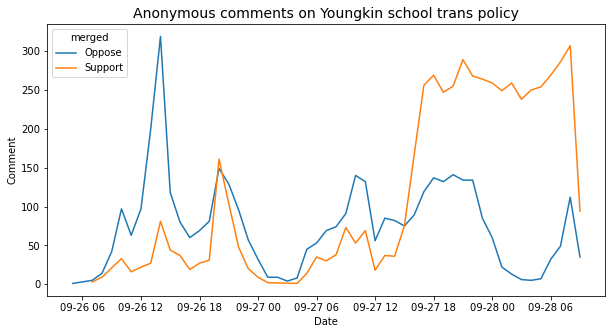

In [250]:
anon_ts = anon.set_index('Date').groupby([pd.Grouper(freq='1h'), 'merged']).count().loc[:,['Comment']].reset_index()

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = 'Date', y = 'Comment', data = anon_ts, hue = 'merged', ax=ax)
ax.set_title('Anonymous comments on Youngkin school trans policy', fontsize=14)
plt.savefig("images/anon_ts.png", facecolor='white')
plt.show()

In [274]:
anon_dups = anon.groupby(['Comment Title','Comment']).agg({"CommentID":'count','Date':['min','max']})
anon_dups.columns = ['count','min_date','max_date']
anon_dups['range'] = (anon_dups['max_date'] - anon_dups['min_date'])
anon_dups.sort_values('range', ascending=False).head(10)

,,count,min_date,max_date,range
Comment Title,Comment,,,,
Strongly support,Strongly support,9,2022-09-26 10:24:00,2022-09-28 09:45:00,1 days 23:21:00
I strongly support,The family unit is the fundamental organizing principle of our society. No government has the right to break up the family unit except under the most extraordinary circumstances. Schools that set themselves up as “substitute parents” are grossly out of bounds. Schools have no right to transition students’ gender without parental consent. They cannot give students Tylenol without parental consent! This policy also protects young women and girls from biological boys with serious mental health problems and preserves women’s right to fair and equitable completion in sports. Thank you to the Youngkin administration for protecting girls and families from the craziness of the trans movement!,16,2022-09-26 18:07:00,2022-09-28 11:23:00,1 days 17:16:00
Support,Thank you,15,2022-09-26 14:48:00,2022-09-28 07:53:00,1 days 17:05:00
Fully support try he policy by Youngkin!,Fully support try he policy by Youngkin!,14,2022-09-26 18:55:00,2022-09-28 11:52:00,1 days 16:57:00
Do it. I completely support.,Northam never should have done this in VA anyway.,13,2022-09-26 19:31:00,2022-09-28 11:55:00,1 days 16:24:00
I support Governor Younkin,Thank you Governor Youngkin for protecting our kids.,18,2022-09-26 18:50:00,2022-09-28 11:06:00,1 days 16:16:00
Fully support,Fully support,20,2022-09-26 20:01:00,2022-09-28 11:57:00,1 days 15:56:00
I strongly support Governor Youngkin's support of parental rights,Governor Youngkin has shown a great concern for the rights and welfare of all students and their parents. I strongly support these documents.,14,2022-09-26 18:57:00,2022-09-28 10:49:00,1 days 15:52:00
I fully support this.,I fully support this.,10,2022-09-26 20:03:00,2022-09-28 11:50:00,1 days 15:47:00


<AxesSubplot:>

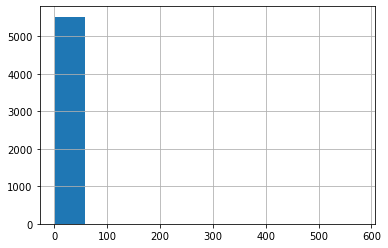

In [275]:
anon_dups['count'].hist()

In [276]:
# drop dups with <5
anon_dups = anon_dups.loc[anon_dups['count']>5]

In [277]:
anon_dups.sort_values('count', ascending=False).head(10)

,,count,min_date,max_date,range
Comment Title,Comment,,,,
LOCK YOUNGKIN UP,As anti american as you can get!,577,2022-09-28 10:18:00,2022-09-28 10:22:00,0 days 00:04:00
VOTE HIM OUT,This is cruel to our children,432,2022-09-28 10:12:00,2022-09-28 10:16:00,0 days 00:04:00
CRUELTY TO OUR CHILDREN,This is as mean as you can get.,316,2022-09-28 10:25:00,2022-09-28 10:28:00,0 days 00:03:00
LOCK YOUNGKIN UP,As anti American as you can get!,195,2022-09-28 10:22:00,2022-09-28 10:24:00,0 days 00:02:00
"No, just no; this policy is DANGEROUS","Man, it's the needless and aggressively insecure policies for me. Transgender kids suffer disproportionally from being homeless, so your solution to ""parental rights"" is to ""inform"" potentially transphobic guardians of a kid's identity, resulting in so many children losing their human right to security of housing.",123,2022-09-28 11:08:00,2022-09-28 11:43:00,0 days 00:35:00
JOHN OLIVER PLEASE TALK ABOUT THIS!!!!!,Shine a light on this terrible policy and Governor,117,2022-09-28 09:29:00,2022-09-28 09:31:00,0 days 00:02:00
MAGA no place in Virginia,All parents agree,87,2022-09-28 09:25:00,2022-09-28 09:26:00,0 days 00:01:00
Parents are against the policy change,Parents do not want these backward policies,65,2022-09-28 09:22:00,2022-09-28 09:23:00,0 days 00:01:00
LGBTQ REPRODUCES BY TOUCHING CHILDREN,,46,2022-09-26 14:36:00,2022-09-26 14:44:00,0 days 00:08:00


In [244]:
anon.set_index(['Comment Title','Comment'], inplace=True)
anon.loc[anon.index.isin(anon_dups.index)]
anon.reset_index()

,Comment Title,Comment,CommentID,Commenter,Date,label,pred,merged
0,Support!,"As a public school teacher, THANK YOU! I don't...",128971.0,Anonymous,2022-09-26 07:31:00,Support,,Support
1,Strongly support all people being who they are,Everyone is different. Everyone deserves to be...,128976.0,Anonymous,2022-09-26 07:38:00,Support,,Support
2,This is about saving student lives - oppose th...,I strongly oppose these changes. Having worked...,128984.0,Anonymous,2022-09-26 07:54:00,Oppose,,Oppose
3,Strongly Oppose The Changes,Correct pronoun and name use is incredibly cri...,128992.0,Anonymous,2022-09-26 08:12:00,Oppose,,Oppose
4,Strongly Oppose,Leave the evangelists to do their Work outside...,128998.0,Anonymous,2022-09-26 08:18:00,Oppose,,Oppose
...,...,...,...,...,...,...,...,...
9620,AGAINST THIS POLICY!!!!,"We are better than this. Move forward, not ba...",156224.0,Anonymous,2022-09-28 09:19:00,Unknown,Oppose,Oppose
9621,AGAINST THIS POLICY!!!!,"We are better than this. Move forward, not ba...",156225.0,Anonymous,2022-09-28 09:19:00,Unknown,Oppose,Oppose
9622,AGAINST THIS POLICY!!!!,"We are better than this. Move forward, not ba...",156226.0,Anonymous,2022-09-28 09:19:00,Unknown,Oppose,Oppose
9623,AGAINST THIS POLICY!!!!,"We are better than this. Move forward, not ba...",156227.0,Anonymous,2022-09-28 09:19:00,Unknown,Oppose,Oppose


In [213]:
anon.loc[(anon['merged']=='Support') & (anon['Date'] > datetime(2022, 9, 28, 2, 0)) & (anon['Comment Title'].str.startswith('I strongly support'))].head(20)

,CommentID,Commenter,Comment Title,Comment,Date,label,pred,merged
24495,153597.0,Anonymous,I strongly support this. As a young woman,I want to feel safe in my sport and bathrooms.,2022-09-28 02:01:00,Support,,Support
24507,153609.0,Anonymous,I strongly support this legislation,Thank you,2022-09-28 02:03:00,Support,,Support
24588,153690.0,Anonymous,I strongly support this policy.,I am a parent and a grandparent. I expect the ...,2022-09-28 02:19:00,Support,,Support
24662,153764.0,Anonymous,I strongly support this legislation,Thank you,2022-09-28 02:36:00,Support,,Support
24668,153770.0,Anonymous,I strongly support Governor Youngkin's support...,Governor Youngkin has shown a great concern fo...,2022-09-28 02:37:00,Support,,Support
24678,153780.0,Anonymous,I strongly support this. As a young woman,I want to feel safe in my sport and bathrooms.,2022-09-28 02:39:00,Support,,Support
24686,153788.0,Anonymous,I strongly support this. As a young woman,I want to feel safe in my sport and bathrooms.,2022-09-28 02:41:00,Support,,Support
24699,153801.0,Anonymous,I strongly support this,Stand strong,2022-09-28 02:44:00,Support,,Support
24736,153838.0,Anonymous,I strongly support Governor Youngkin's support...,Governor Youngkin has shown a great concern fo...,2022-09-28 02:53:00,Support,,Support
24758,153860.0,Anonymous,I strongly support this. As a young woman,I want to feel safe in my sport and bathrooms.,2022-09-28 02:57:00,Support,,Support


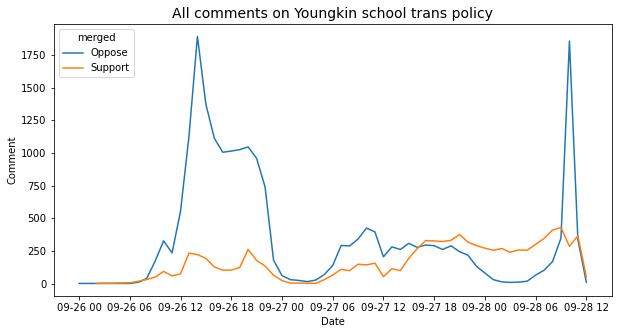

In [273]:
output_df['merged'] = output_df['pred'].replace('',np.NaN).fillna(output_df['label'])
out_ts = output_df.set_index('Date').groupby([pd.Grouper(freq='1h'), 'merged']).count().loc[:,['Comment']].reset_index()

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = 'Date', y = 'Comment', data = out_ts, hue = 'merged', ax=ax)
ax.set_title('All comments on Youngkin school trans policy', fontsize=14)
plt.savefig("images/all_ts.png", facecolor='white')
plt.show()